In [2]:
# !pip install lava-nc
# !pip install networkx==2.8
# !pip install matplotlib
# !pip install cvxpy
# !pip install lava-nc
# !pip install pandas

In [3]:
# import lava
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cProfile

In [4]:
def graph_to_mat(G, path = 'test_graphs/default2.mat'):
    # get the adjancency matrix of the graph
    adj = nx.adjacency_matrix(G).todense()
    adj = np.asarray(adj, dtype=np.int32)
    scipy.io.savemat(path, {'M': adj})   # M for matrix, to stay consistent with the .mat files we already have
    return

def mat_to_graph(path):
    mat = scipy.io.loadmat(path)
    G = nx.from_numpy_array(mat['M'])
    return G

In [5]:
def gen_permutation_matrix(phi):
    n = phi.shape[0]
    order = np.argsort(phi)
    P = np.zeros((n, n))
    for i in range(n):
        P[i,order[i]] = 1  # orignally P[i,order[i]] = 1
    return P, order

def get_chr(P, A, order):
    n = A.shape[0]
    PAPT = (P @ A) @ P.T
    block_list = []
    color_blocks = []
    i = 0
    while (i<n):
        condition = 0
        block = 0
        color_block = []
        while (condition==0 and (i+block)<n):
            #if PAPT[i:i+block+1,i:i+block+1] == np.zeros((block+1,block+1)):
            if np.sum(np.abs(PAPT[i:i+block+1,i:i+block+1])) == 0:
                color_block.append(order[i+block])
                block = block+1
            else:
                condition = 1
        block_list.append(block)
        color_blocks.append(color_block)
        i = i + block
    return len(block_list), color_blocks

def get_color_indice_array(color_blocks, adj):
    color_indice_array = np.zeros(adj.shape[0], dtype=np.int32)
    temp_color_index = 0
    for color_block in color_blocks:
        for node in color_block:
            color_indice_array[node] = temp_color_index
        temp_color_index += 1
    num_colors = temp_color_index
    return color_indice_array, num_colors

def density(adj_matrix):
    return np.sum(adj_matrix) / (adj_matrix.shape[0] * (adj_matrix.shape[1]-1))

def get_color_adj_graph(color_indice_array, adj, num_colors):
    color_adj = np.zeros((num_colors,num_colors), dtype=np.int32)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if adj[i][j] == 1:
                color_adj[color_indice_array[i]][color_indice_array[j]] = 1
    return color_adj

def loss(phi_history,adj):
    num_nodes = adj.shape[0]
    loss_list = []
    for i in range (len(phi_history)):
        curr_phi = phi_history[i]
        loss = 0
        for j in range (num_nodes):
            for k in range (j):
                if(adj[j][k] == 1):
                    loss -= 1 - np.cos(curr_phi[j] - curr_phi[k])
        loss_list.append(loss)
    return loss_list

def gen_cyclic_graph(n):
    B = np.zeros((n, n))
    for i in range(n):
        B[i,i-1] = 1.0
        B[i,(i+1)%n] = 1.0
    return B

In [6]:
phi_diff = [1,2,3]
phi_diff = np.array(phi_diff)
phi_diff = np.reshape(phi_diff, (3,))
print(phi_diff.shape)
x=phi_diff[:,None]-phi_diff
print(x.shape)

(3,)
(3, 3)


In [122]:
def graph_painter_exp_online(adj, num_iters = 3,sigma_exp_list = [1], sigma_noise_list = [0], phi_init = None, step_size_list = [0.1], central_term_only = False):
    n = adj.shape[0]
    # phi = uniform randomly between -1 and 1
    if phi_init is None:
        curr_phi = np.random.uniform(-1, 1, n)*np.pi*0.5
    else:
        curr_phi = phi_init
    min_colors = n
    best_coloring = [[i] for i in range(n)]
    phi_history = []
    phi_history.append(curr_phi)
    total_iter_cnt = 0
    for step_size in step_size_list:
        for sigma_exp in sigma_exp_list:
            for sigma_noise in sigma_noise_list:
                # print(f"step_size: {step_size}, sigma_exp: {sigma_exp}, sigma_noise: {sigma_noise}")
                for i in range(num_iters):
                    # update phi
                    total_iter_cnt += 1
                    curr_phi = curr_phi + sigma_noise*np.random.randn(n)
                    # compute the loss derivative
                    phi_curr = np.reshape(curr_phi, (curr_phi.shape[0],))
                    x = phi_curr[:, None] - phi_curr
                    term1 = -np.sign(x) * np.exp(-np.abs(x) / sigma_exp)/sigma_exp
                    term1[x == 0] = 0
                    np.fill_diagonal(term1, 0) # to avoid self-derivative


                    term2 = np.exp((x - 2 * np.pi) / sigma_exp)/sigma_exp # Sign not needed as x < 2pi
                    # print(np.max(term2))
                    np.fill_diagonal(term2, 0)

                    term3 = -np.exp(-(x + 2 * np.pi) / sigma_exp)/sigma_exp # Sign not needed as x < 2pi
                    np.fill_diagonal(term3, 0)
                    loss_derivative = term1 + term2 + term3
                    loss_derivative_clip = np.clip(loss_derivative, -10, 10)
                    # The clipping is important. Because of noise, two connected nodes can come close and
                    # blow up the derivative.
                    curr_phi = curr_phi - step_size* np.sum(adj*loss_derivative_clip, axis=1)
                    curr_phi[curr_phi > np.pi] = curr_phi[curr_phi > np.pi] - 2*np.pi
                    curr_phi[curr_phi < -np.pi] = curr_phi[curr_phi < -np.pi] + 2*np.pi
                    phi_history.append(curr_phi)
                    P, order = gen_permutation_matrix(curr_phi)
                    num_chr, color_blocks = get_chr(P, adj, order)
                    if num_chr < min_colors:
                        print(total_iter_cnt, " ", num_chr)
                        min_colors = num_chr
                        best_coloring = color_blocks
                    # convert phi_history to numpy array
    phi_history = np.array(phi_history)
    return min_colors, best_coloring, phi_history


/tmp/ipykernel_4408/1121049539.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
/tmp/ipykernel_4408/1121049539.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
/tmp/ipykernel_4408/1121049539.py:21: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
/tmp/ipykernel_4408/1121049539.py:31: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


Density of the original graph:  0.6
1   4
Density of the colored graph:  0.8333333333333334
Num Colors:  4
[[0], [2, 5, 3], [1], [4]]
[0.19744842 0.43580678 0.48904824 0.98409154 0.         1.15053029]


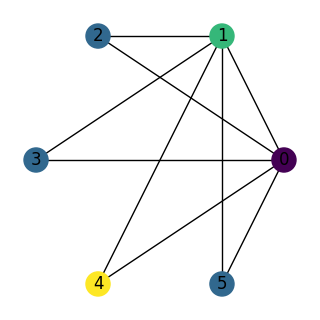

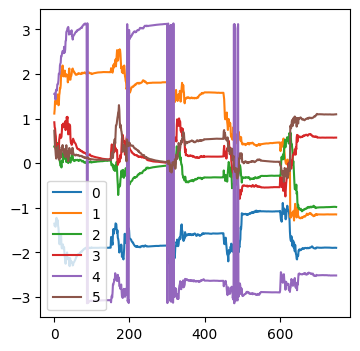

(751, 6)


In [123]:
# read myciel4 graph
# G = mat_to_graph('test_graphs/dsjc125.5.mat')
# G = complete graph with 3 nodes

n = 3
# # craete a complete graph
G = nx.complete_graph(n)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
# add a new node
G.add_node(n)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
for i in range(n-1):
    G.add_edge(i, n)
    G.add_edge(n, i)
    adj[i][n] = 1
    adj[n][i] = 1

G.add_node(n+1)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
for i in range(n-1):
    G.add_edge(i, n+1)
    G.add_edge(n+1, i)
    adj[i][n+1] = 1
    adj[n+1][i] = 1
# print(adj)

G.add_node(n+2)
adj = nx.adjacency_matrix(G).toarray()
adj = np.asarray(adj, dtype=np.int32)
for i in range(n-1):
    G.add_edge(i, n+2)
    G.add_edge(n+2, i)
    adj[i][n+2] = 1
    adj[n+2][i] = 1

# adj = gen_cyclic_graph(17)
# G = nx.from_numpy_array(adj)

density_original = density(adj)
print("Density of the original graph: ", density_original)
num_colors, coloring, phi_history = graph_painter_exp_online(adj, num_iters=50, sigma_exp_list=[1,0.5,0.1,0.05,0.01], sigma_noise_list=[0.1, 0.01, 0.001], step_size_list=[0.1], central_term_only=False)
color_indice_array, _ = get_color_indice_array(coloring, adj)
density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
print("Density of the colored graph: ", density_colored)
print("Num Colors: ", num_colors)
print(coloring)
print((np.asarray(phi_history[-1])-np.min(np.asarray(phi_history[-1])))/np.pi)

# Plot the graph with the coloring
plt.figure(figsize=(3, 3))
nx.draw_circular(G, with_labels=True, node_color=color_indice_array)
plt.show()

# plot the phi history row wise
plt.figure(figsize=(4,4))
plt.plot(phi_history)
plt.legend([i for i in range(adj.shape[0])])
plt.show()

print(phi_history.shape)

In [124]:
small_graph_names = ['huck', 'myciel3', 'myciel4', 'myciel5', 'myciel6', 'david', 'queen55', 'queen66', 'queen77']
small_graph_names = ['queen77']
# small_graph_names = ['queen77']

# sigma_exp_list = [0.1, 0.2, 0.3, 0.4, 0.5]
# sigma_exp_list = [0.04, 0.05, 0.06, 0.07, 0.08]
num_iters=100
# sigma_exp_list=[1,0.33,0.1,0.033, 0.01]
# sigma_noise_list=[0.1, 0.01, 0.001]
# step_size_list=[0.1, 0.01, 0.001]
sigma_exp_list=[0.3,0.3,1,3]
sigma_noise_list=[0.1]
step_size_list=[0.1]
for graph_name in small_graph_names:
    G = mat_to_graph('test_graphs/'+graph_name+'.mat')
    adj = nx.adjacency_matrix(G).toarray()
    adj = np.asarray(adj, dtype=np.int32)
    density_original = density(adj)
    # num_colors, coloring, phi_history = graph_painter_exp_color_based_exp(adj, num_iters=4000, sigma_noise=0.07, step_size=0.1, central_term_only=False)
    num_colors, coloring, phi_history = graph_painter_exp_online(adj, num_iters=num_iters, sigma_exp_list=sigma_exp_list, sigma_noise_list=sigma_noise_list, step_size_list=step_size_list, central_term_only=False)
    color_indice_array, _ = get_color_indice_array(coloring, adj)
    density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
    if density_colored !=1:
        print(get_color_adj_graph(color_indice_array, adj, num_colors))
    print("Graph name: ", graph_name)
    print("Density of the colored graph: ", density_colored)
    print("Num Colors: ", num_colors)

1   22
2   21
6   18
7   17
22   16
32   15
34   14
49   13


/tmp/ipykernel_4408/2956613849.py:16: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


143   12
247   11
Graph name:  queen77
Density of the colored graph:  1.0
Num Colors:  11


In [125]:
coloring

[[31, 8, 35, 6],
 [19, 41, 32, 22, 2],
 [47, 21, 11, 38, 1],
 [42, 20, 40, 29, 25, 10],
 [0, 44, 33, 13],
 [14, 39, 3],
 [30, 48, 26, 17, 7, 4],
 [37, 15, 24, 5],
 [43, 18, 28, 23],
 [34, 12, 45, 16],
 [36, 27, 46, 9]]

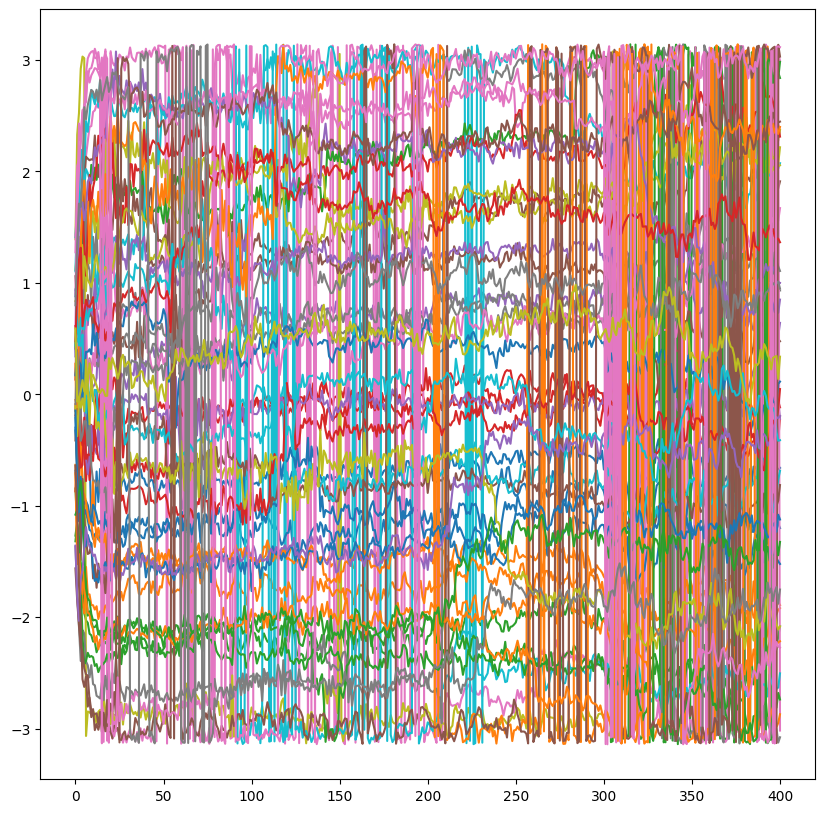

In [126]:
# Plot phi history
plt.figure(figsize=(10,10))
plt.plot(phi_history)
# plt.legend([i for i in range(adj.shape[0])])
plt.show()

In [138]:
graph_names_large = ['dsjc125.1', 'dsjc125.5', 'dsjc250.5', 'dsjc500.1', 'dsjc500.5', 'dsjc500.9']
graph_names_large = ['dsjc250.5']
num_iters=3000
# sigma_exp_list=[1,0.33,0.1,0.033,0.01]
# sigma_noise_list=[0.1, 0.01, 0.001]
# step_size_list=[0.1, 0.01, 0.001]
sigma_exp_list=[0.3]
sigma_noise_list=[ 0.03]
step_size_list=[0.01]
for graph_name in graph_names_large:
    G = mat_to_graph('test_graphs/'+graph_name+'.mat')
    adj = nx.adjacency_matrix(G).toarray()
    adj = np.asarray(adj, dtype=np.int32)
    density_original = density(adj)
    # num_colors, coloring, phi_history = graph_painter_exp_color_based_exp(adj, num_iters=4000, sigma_noise=0.07, step_size=0.1, central_term_only=False)
    num_colors, coloring, phi_history = graph_painter_exp_online(adj, num_iters=num_iters, sigma_exp_list=sigma_exp_list, sigma_noise_list=sigma_noise_list, step_size_list=step_size_list, central_term_only=False)
    color_indice_array, _ = get_color_indice_array(coloring, adj)
    density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
    print("Graph name: ", graph_name)
    print("Density of the colored graph: ", density_colored)
    print("Num Colors: ", num_colors)

/tmp/ipykernel_4408/626307335.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


1   136
2   119
4   108
7   107
8   104
9   97
10   94
11   88
14   87
15   86
16   83
19   82
23   79
25   77
31   76
32   75
36   74
40   73
41   72
48   70
68   68
99   65
196   64
208   63
423   62
424   61
790   60
1032   59
2173   58
2211   57
Graph name:  dsjc250.5
Density of the colored graph:  0.9981203007518797
Num Colors:  57


In [84]:
graph_names_large = ['dsjc500.5', 'dsjc500.9']

num_iters=100
sigma_exp_list=[1,0.33,0.1,0.033,0.01, 0.0033]
sigma_noise_list=[0.01, 0.001, 0.0001]
step_size_list=[0.001, 0.0001, 0.00001]
for graph_name in graph_names_large:
    G = mat_to_graph('test_graphs/'+graph_name+'.mat')
    adj = nx.adjacency_matrix(G).toarray()
    adj = np.asarray(adj, dtype=np.int32)
    density_original = density(adj)
    # num_colors, coloring, phi_history = graph_painter_exp_color_based_exp(adj, num_iters=4000, sigma_noise=0.07, step_size=0.1, central_term_only=False)
    num_colors, coloring, phi_history = graph_painter_exp_online(adj, num_iters=num_iters, sigma_exp_list=sigma_exp_list, sigma_noise_list=sigma_noise_list, step_size_list=step_size_list, central_term_only=False)
    color_indice_array, _ = get_color_indice_array(coloring, adj)
    density_colored = density(get_color_adj_graph(color_indice_array, adj, num_colors))
    print("Graph name: ", graph_name)
    print("Density of the colored graph: ", density_colored)
    print("Num Colors: ", num_colors)

/tmp/ipykernel_13572/964533369.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()


Graph name:  dsjc500.5
Density of the colored graph:  0.9991809991809992
Num Colors:  111
Graph name:  dsjc500.9
Density of the colored graph:  0.9916902679655162
Num Colors:  254


In [ ]:

graph_names_large = ['dsjc125.1', 'dsjc125.5', 'dsjc250.5', 'dsjc500.1', 'dsjc500.5', 'dsjc500.9']
num_runs = 5
num_colors_graph_painter2 = []
num_colors_graph_painter2_scaled = []
num_colors_graph_painter_basic = []
num_colors_random_ordering = []
density_list = []
num_nodes_list = []

for graph_name in graph_names_large:
    G = mat_to_graph('test_graphs/'+graph_name+'.mat')
    adj = nx.adjacency_matrix(G).toarray()
    adj = np.asarray(adj, dtype=np.int32)
    num_colors_list_graph_painter2 = []
    num_colors_list_graph_painter2_scaled = []
    num_colors_list_graph_painter_basic = []
    num_colors_list_random_ordering = []
    print("Graph: ", graph_name)
    density_temp = density(adj)
    # Trim density to 4 decimal places
    density_temp = float("{:.4f}".format
                         (density_temp))
    density_list.append(density_temp)
    num_nodes_list.append(adj.shape[0])
    print("Density of the graph: ", density_temp)
    print()
    for i in range(num_runs):
        num_colors, _, _ = graph_painter2(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
        num_colors_list_graph_painter2.append(num_colors)

        num_colors, _, _ = graph_painter2_scaled(adj, num_iters = 2000, sigma_noise = 0.0, step_size = 0.01)
        num_colors_list_graph_painter2_scaled.append(num_colors)

        color_blocks, _, _ = graph_painter_basic(adj)
        num_colors = len(color_blocks)
        num_colors_list_graph_painter_basic.append(num_colors)

        random_phases = np.random.uniform(-np.pi, np.pi, adj.shape[0])
        P, order = gen_permutation_matrix(random_phases)
        num_chr, color_blocks = get_chr(P, adj, order)
        if num_chr != len(color_blocks):
            print("ERROR IN RANDOM ORDERING")
        num_colors_list_random_ordering.append(num_chr)

    num_colors_graph_painter2.append(num_colors_list_graph_painter2)
    num_colors_graph_painter2_scaled.append(num_colors_list_graph_painter2_scaled)
    num_colors_graph_painter_basic.append(num_colors_list_graph_painter_basic)
    num_colors_random_ordering.append(num_colors_list_random_ordering)

num_colors_random_ordering = np.array(num_colors_random_ordering)
# Make a box plot for each graph with all the methods
for i in range(len(graph_names_large)):
    plt.figure(figsize=(6,4))
    plt.boxplot([num_colors_graph_painter2[i], num_colors_graph_painter2_scaled[i], num_colors_graph_painter_basic[i]], labels=['Graph painter2', 'Graph painter2 Scaled', 'Graph Painter Basic'])
    plt.title(graph_names_large[i] + ', Density = ' + str(density_list[i]) + ', Num Nodes = ' + str(num_nodes_list[i]))
    plt.show()
    print("Average Random Ordering: ", np.mean(num_colors_random_ordering[i]))
    print()